# Assignment 4 - Image Classification with Convolutional Neural Networks

In this assignment, you will build a ConvNet for solving an image classification problem. You will be working on a fashion/clothing dataset, where the goal is to categorize the items according to two criteria:
 
 - **Clothing type**: Shirts, dresses, jeans, shoes.
 - **Color**: Red, blue, black.
 
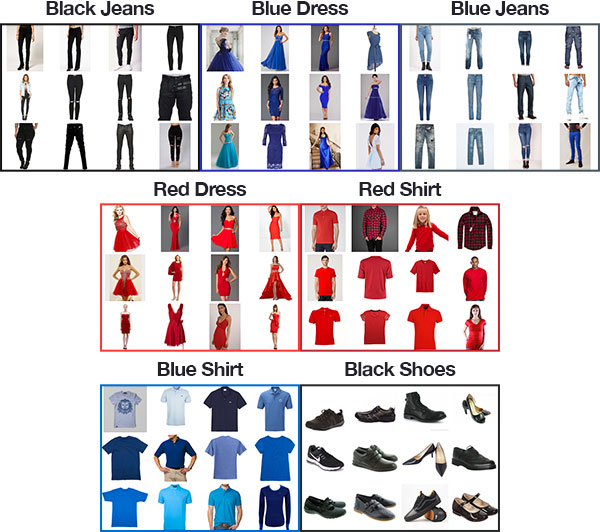

You will tackle this problem in incremental steps:
 
 1. build a **multi-class classifier**, where each pair of clothing type and color is a different class;
 
 - build a **multi-label classifier**, where your ConvNet has a different output for each possible sub-class (shirt, dress, jeans, shoes, red, blue, black), and they can be activated simultaneously in order to predict the clothing type and color.
 
 - build a **multi-output classifier**, where your ConvNet has two output heads, one for predicting the clothing type, and the other for predicting the color.
 
This assignment is open-ended. Your goal is to maximize the performance of your ConvNets by using all the tricks you have learned in the course.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras import utils, layers, models, optimizers
from keras.preprocessing import image

from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer

Using TensorFlow backend.


## 1. Fashion Dataset

The dataset consists of 2525 images across seven combinations of clothing type and color:

 - Black jeans (344 images)
 - Black shoes (358 images)
 - Blue dress (386 images)
 - Blue jeans (356 images)
 - Blue shirt (369 images)
 - Red dress (380 images)
 - Red shirt (332 images)

These images were downloaded via the Bing Image Search API. The entire process of downloading the images and manually removing the irrelevant ones for each of the seven combinations took approximately 30 minutes. 

#### Data Preprocessing

As you already know, data should be formatted into appropriately pre-processed floating-point tensors before being fed into your networks. Currently, your data sits on a drive as JPEG files, so the steps for getting it into a network are roughly:
* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating-point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows you to quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. Read the [doc](https://keras.io/preprocessing/image/) for more information.

**Tips:** If you want to use data augmentation at a later time, come back here and create a new `ImageDataGenerator` with the appropriate parameters.

In [2]:
# target image size
n_pix = 40

# All images will be rescaled by 1./255
datagen = image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

# train set
train_generator = datagen.flow_from_directory("fashion_dataset", subset='training', target_size=(n_pix,n_pix), batch_size=32)

# validation set
valid_generator = datagen.flow_from_directory("fashion_dataset", subset='validation', target_size=(n_pix,n_pix), batch_size=501)


Found 2020 images belonging to 7 classes.
Found 501 images belonging to 7 classes.


Let's take a look at the output of these generators. They yield batches of 40x40 RGB images and their corresponding labels, with 32 samples in each batch. Note that a generator yields these batches indefinitely: it just loops endlessly over the images present in the target folder.

data batch shape: (32, 40, 40, 3)
data label shape: (32, 7)


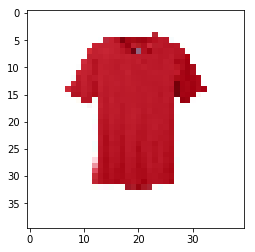

In [3]:
for data_batch, labels_batch in train_generator:
    
    print('data batch shape:', data_batch.shape)
    print('data label shape:', labels_batch.shape)
    
    plt.imshow(data_batch[0])
    plt.show()
    
    break

The labels are one-hot encoded, as shown in the cell below.

In [4]:
for key, value in train_generator.class_indices.items():
    print(utils.to_categorical(value, num_classes=7), "=", value, "-->", key)

[1. 0. 0. 0. 0. 0. 0.] = 0 --> black_jeans
[0. 1. 0. 0. 0. 0. 0.] = 1 --> black_shoes
[0. 0. 1. 0. 0. 0. 0.] = 2 --> blue_dress
[0. 0. 0. 1. 0. 0. 0.] = 3 --> blue_jeans
[0. 0. 0. 0. 1. 0. 0.] = 4 --> blue_shirt
[0. 0. 0. 0. 0. 1. 0.] = 5 --> red_dress
[0. 0. 0. 0. 0. 0. 1.] = 6 --> red_shirt


#### Training with data generators

So far, we used the `.fit()` method to train a neural network. This method expects two NumPy arrays containing the training data and labels, and some other parameters such as `epochs` and `batch_size`. Here is an example.
 
```python
model.fit(train_data, train_labels, epochs=50, batch_size=1000)
```

Alternatively, we can train a neural network using the generator that we defined earlier. We do it by using the `.fit_generator()` method, the equivalent of `.fit()` for data generators. This method expects as first argument a Python generator that will yield batches of inputs and targets indefinitely. Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. For example, if the batches are 32-sample large and the total number of samples is $N$, it will take $N/32$ batches until we see all the samples.

When using `.fit_generator()`, we may pass a `validation_data` argument, much like with the `.fit()` method. Importantly, this argument is allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, which tells the process how many batches to draw from the validation generator for evaluation.

Here is an usage example of `.fit_generator()` with our generators defined earlier. 

```python
model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      validation_data=valid_generator,
      validation_steps=1,
      epochs=50)
```

Here above, `steps_per_epoch` is set to 63 because we have 2020 training samples, and we fixed 32-sample batched in `train_generator`, thus yielding $63 \approx \frac{2020}{32}$. Similarly, `validation_steps` is set to 1 because we have 501 validation samples, and we fixed 501-sample batched in `valid_generator`, thus yielding $1 = \frac{501}{501}$. Note that `epochs` has the same meaning as in `.fit()`.

## 2. Multi-Class Classification

**Exercise:** Build a ConvNet for multi-class classification. It must predict the 7 classes available in the dataset.

- Define the architecture of your ConvNet.

- Fit the ConvNet on the training set.

- Evaluate its performance on the validation set.

- Test your trained ConvNet on the images in the folder `fashion_examples`.

**Tips:**

 - Remember that the structure of a ConvNet starts off with a stack of alternated `Conv2D => Relu` and `MaxPooling2D` layers, which are then followed by a `Flatten` layer and several `Dense` layers. 
 
 
 - Use a **small network**, otherwise you will not be able to train it on your computer.
 
 
 - Since you are dealing with multi-class classification, you end the network with a `softmax` activation. The number of units in this last layer is equal to the number of classes to predict. Each output will encode the probability that the network is looking at one of the classes.
 
 
 - For multi-class classification, the loss function is `categorical_crossentropy`.

#### Depth-wise Separable Convolution

There’s a layer you can use as a drop-in replacement for `Conv2D` that will make your model lighter (fewer trainable weight parameters) and faster (fewer floating-point operations), and cause it to perform a few percentage points better on its task. That is precisely what the depthwise separable convolution layer does, which is called
`SeparableConv2D` in Keras. 

This layer performs a spatial convolution on each channel of its input, independently, before mixing output channels via a pointwise convolution (a 1x1 convolution). This is equivalent to separating the learning
of spatial features and the learning of channel-wise features, which makes a lot of
sense if you assume that spatial locations in the input are highly correlated, but different
channels are fairly independent. It requires significantly fewer parameters and
involves fewer computations, thus resulting in smaller, speedier models. And because
it’s a more representationally efficient way to perform convolution, it tends to learn
better representations using less data, resulting in better-performing models.

These advantages become especially important when you’re training small models
from scratch on limited data. For instance, here’s how you can build a lightweight,
depthwise separable convnet for an image-classification task (softmax categorical classification)
on a small dataset.

In [24]:
# Define the network
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(40, 40, 3)))     # ADD CODE HERE
model.add(layers.MaxPooling2D((2, 2)))    # ADD CODE HERE
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)) )
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))#number of class= number of prediction
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # ADD CODE HERE

# Train the network. Hint: use .fit_generator(...)
history =model.fit_generator( train_generator,steps_per_epoch=63,validation_data=valid_generator,validation_steps=1,epochs=5) # ADD CODE HERE

Epoch 1/5
63/63 [==============================] - 50s 786ms/step - loss: 0.8384 - acc: 0.6954 - val_loss: 0.5845 - val_acc: 0.8024
Epoch 2/5
63/63 [==============================] - 52s 829ms/step - loss: 0.3762 - acc: 0.8592 - val_loss: 0.1997 - val_acc: 0.9341
Epoch 3/5
63/63 [==============================] - 52s 827ms/step - loss: 0.2723 - acc: 0.9023 - val_loss: 0.1759 - val_acc: 0.9361
Epoch 4/5
63/63 [==============================] - 46s 728ms/step - loss: 0.2047 - acc: 0.9295 - val_loss: 0.1216 - val_acc: 0.9521
Epoch 5/5
63/63 [==============================] - 48s 755ms/step - loss: 0.1834 - acc: 0.9390 - val_loss: 0.1340 - val_acc: 0.9501


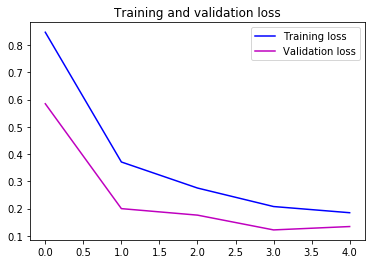

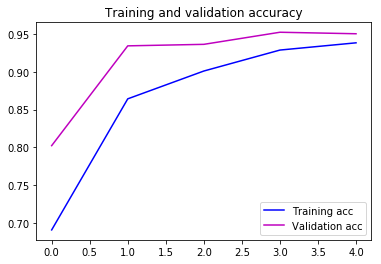

In [25]:
# Get the training info
loss     = history.history['loss']
val_loss = history.history['val_loss']
acc      = history.history['acc']
val_acc  = history.history['val_acc']

# Visualize the history plots
plt.figure()
plt.plot(loss, 'b', label='Training loss')
plt.plot(val_loss, 'm', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(acc, 'b', label='Training acc')
plt.plot(val_acc, 'm', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

**Expected Output**:

<table>
    <tr>
        <td>
            Accuracy on validation set
        </td>
        <td>
           around 95%
        </td>
    </tr>
</table>

Found 9 images belonging to 1 classes.
[0 1 6 2 6 2 5 3 4]


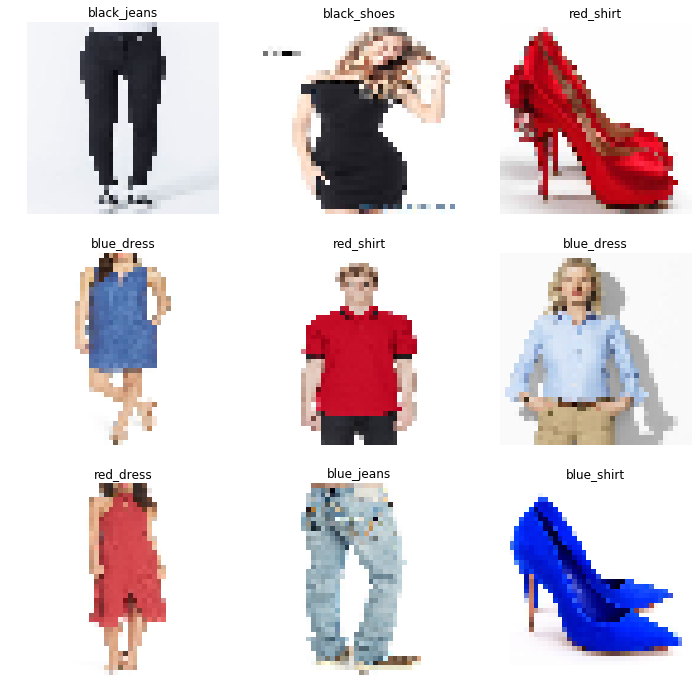

In [40]:
# Get the class names from the training set
classes = list(train_generator.class_indices.keys())

# Read the test images
test_generator = datagen.flow_from_directory("fashion_examples", class_mode=None, target_size=(n_pix,n_pix), batch_size=9)
test_images = next(test_generator)

# Test the network. Hint: use .predict() and .argmax()
preds  = model.predict(test_images) # ADD CODE HERE
labels = preds.argmax(axis=1) # ADD CODE HERE
print(labels)
# Visualize the predictions
f, ax = plt.subplots(3, 3, figsize=(12,12))
for i, img in enumerate(test_images):
    ax.flat[i].imshow(img)
    ax.flat[i].axis("off")
    ax.flat[i].set_title(classes[labels[i]])
plt.show()

Analyze the errors made by your ConvNet on the test images. 

- A fraction of them is due to images classified in the wrong category. This kind of errors can be corrected by training a deeper ConvNet, and by reducing the downsampling factor on the input images (we drastically reduced the image resolution to keep the ConvNet small). 


- However, there are some images that your ConvNet can never get right, such as the black dress, the red shoes, and the blue shoes. This happens because there is no example in the training set that corresponds to black dresses, red shoes, or blue shoes. Consequently, the model does not know how to classify them. But the ConvNet is still trained to distinguish colors and clothing types. So, how can you exploit this intrinsic knowlenge of your ConvNet to correctly classify new categories of clothing? Let's find out!

## 3. Multi-Class vs Multi-Label

In **multi-class** classification, the model provides one separate output for each class in the training set. This is exactly what you did earlier: you built a ConvNet with as many outputs as the available classes. The mapping between the network outputs and the 7 classes in the fashion dataset is as follows:
 - Output 1 = Black Jeans 
 - Output 2 = Black Shoes 
 - Output 3 = Blue Dress 
 - Output 4 = Blue Jeans 
 - Output 5 = Blue Shirt 
 - Output 6 = Red Dress 
 - Output 7 = Red Shirt
 
The cell below shows the one-hot encoded labels for each class.

In [41]:
for key, value in train_generator.class_indices.items():
    print(utils.to_categorical(value, num_classes=7), "-->", key)

[1. 0. 0. 0. 0. 0. 0.] --> black_jeans
[0. 1. 0. 0. 0. 0. 0.] --> black_shoes
[0. 0. 1. 0. 0. 0. 0.] --> blue_dress
[0. 0. 0. 1. 0. 0. 0.] --> blue_jeans
[0. 0. 0. 0. 1. 0. 0.] --> blue_shirt
[0. 0. 0. 0. 0. 1. 0.] --> red_dress
[0. 0. 0. 0. 0. 0. 1.] --> red_shirt


In **multi-label** classification, the model uses a different output convention: it provides one seperate output for each sub-class in the training set, provided that the samples belong to more than one category. For example, the fashion dataset includes two categories with several sub-classes:

- **Category 1** = Clothing type
   - *Sub-class 1.1* = Jeans
   - *Sub-class 1.2* = Shoes
   - *Sub-class 1.3* = Dress
   - *Sub-class 1.4* = Shirt
   
   
- **Category 2** = Clothing color
   - *Sub-class 2.1* = Black
   - *Sub-class 2.2* = Blue
   - *Sub-class 2.3* = Red
   
Hence, the multi-label approach implies that the mapping between the network outputs and the 7 sub-classes in the fashion dataset is as follows:
 - Output 1 = Black 
 - Output 2 = Blue
 - Output 3 = Dress 
 - Output 4 = Jeans 
 - Output 5 = Red
 - Output 6 = Shirt
 - Output 7 = Shoes

The key difference here is that an item can be associated to multiple sub-classes. The cell below shows the one-hot encoded labels for the fashion dataset. Remark the difference with respect to the multi-class approach!

**Note:** It is just a coincidence that the number of sub-classes is 7. This number is **not** related to multi-class classification, in which the classes were also 7.

In [42]:
labels = []
for key, value in train_generator.class_indices.items():
    labels.append( key.split("_") )

mlb = MultiLabelBinarizer()
multi_labels = mlb.fit_transform(labels)

for i in range(multi_labels.shape[0]):
    tags = mlb.inverse_transform(multi_labels[[i]])
    print(multi_labels[i], "-->", " ".join(*tags))

[1 0 0 1 0 0 0] --> black jeans
[1 0 0 0 0 0 1] --> black shoes
[0 1 1 0 0 0 0] --> blue dress
[0 1 0 1 0 0 0] --> blue jeans
[0 1 0 0 0 1 0] --> blue shirt
[0 0 1 0 1 0 0] --> dress red
[0 0 0 0 1 1 0] --> red shirt


With a multi-label encoding, you can represent all the possible combinations of clothing types and colors.

In [43]:
new_labels = ["black_dress", "blue_shoes", "red_shoes"]

multi = mlb.transform([l.split("_") for l in new_labels])

for i in range(len(new_labels)):
    print(multi[i], "-->", labels[i])

[1 0 1 0 0 0 0] --> ['black', 'jeans']
[0 1 0 0 0 0 1] --> ['black', 'shoes']
[0 0 0 0 1 0 1] --> ['blue', 'dress']


The following class extends the Keras generator, so as to produce the multi-label one-hot encoding.

In [44]:
class MultilabelGenerator:
    
    def __init__(self, generator):
        self.generator = generator
        self.classes = np.array([key for key, value in generator.class_indices.items()])
        labels = [tag.split("_") for tag in self.classes]
        self.mlb = MultiLabelBinarizer()
        self.mlb.fit(labels)
                
    def __next__(self):
        batch_x, batch_y = self.generator.next()
        idx = batch_y.argmax(axis=1)
        batch_y = self.classes[idx]
        batch_y = [tag.split("_") for tag in batch_y]
        batch_y = self.mlb.transform(batch_y)
        return batch_x, batch_y

The code below prepares the generators for multi-label classification.

In [45]:
train_generator_multilabel = MultilabelGenerator(train_generator)
valid_generator_multilabel = MultilabelGenerator(valid_generator)

## 4. Multi-Label Classification

**Exercise:** Build a ConvNet for multi-label classification. It must predict the 7 sub-classes in the fashion dataset.

- Define the architecture of your ConvNet.

- Fit the ConvNet on the training set.

- Evaluate its performance on the validation set.

- Test your trained ConvNet on the images in the folder `fashion_examples`.

**Tips:**

 - Since you are dealing with *multi-label* classification, you end the network with a `sigmoid` activation. The number of units in this last layer is equal to the number of sub-classes to predict. Each output will encode the probability that the network is looking at one of those sub-classes.
 
 
 - For multi-label classification, the loss function is `binary_crossentropy`.

In [49]:
# Define the network
model = models.Sequential()
# ADD CODE HERE
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(40, 40, 3)))     # ADD CODE HERE
model.add(layers.MaxPooling2D((2, 2)))    # ADD CODE HERE
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)) )
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(7, activation='sigmoid'))#number of class= number of prediction
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # ADD CODE HERE
# Train the network. Hint: use .fit_generator(...)
history = model.fit_generator( train_generator_multilabel,steps_per_epoch=63,validation_data=valid_generator_multilabel,validation_steps=1,epochs=5) # ADD CODE HERE

Epoch 1/5
63/63 [==============================] - 50s 797ms/step - loss: 0.3048 - acc: 0.8657 - val_loss: 0.1031 - val_acc: 0.9575
Epoch 2/5
63/63 [==============================] - 52s 833ms/step - loss: 0.1036 - acc: 0.9622 - val_loss: 0.0532 - val_acc: 0.9832
Epoch 3/5
63/63 [==============================] - 51s 805ms/step - loss: 0.0730 - acc: 0.9705 - val_loss: 0.0414 - val_acc: 0.9866
Epoch 4/5
63/63 [==============================] - 50s 789ms/step - loss: 0.0656 - acc: 0.9760 - val_loss: 0.0321 - val_acc: 0.9900
Epoch 5/5
63/63 [==============================] - 48s 761ms/step - loss: 0.0549 - acc: 0.9790 - val_loss: 0.0362 - val_acc: 0.9866


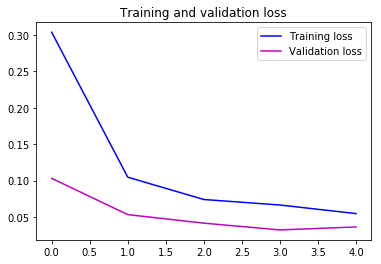

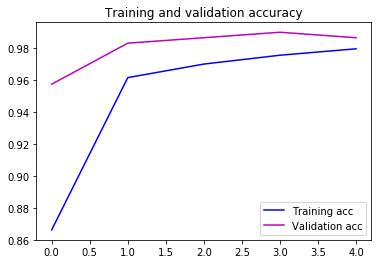

In [50]:
# Get the training info
loss     = history.history['loss']
val_loss = history.history['val_loss']
acc      = history.history['acc']
val_acc  = history.history['val_acc']

# Visualize the history plots
plt.figure()
plt.plot(loss, 'b', label='Training loss')
plt.plot(val_loss, 'm', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(acc, 'b', label='Training acc')
plt.plot(val_acc, 'm', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

**Expected Output**: 

<table>
    <tr>
        <td>
            Accuracy on validation set
        </td>
        <td>
           around 98%
        </td>
    </tr>
</table>

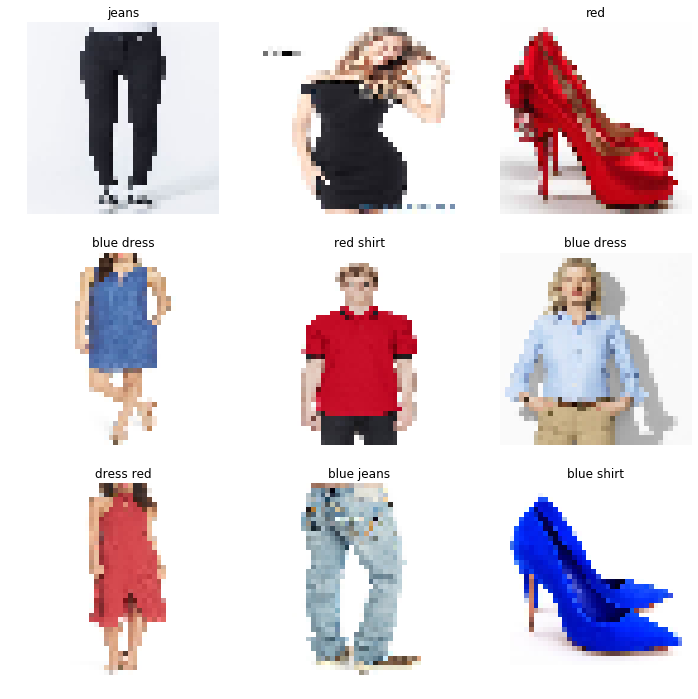

In [51]:
# Test the network
preds = model.predict(test_images)
preds = preds > 0.7

# Get the multi-label categories
tags = train_generator_multilabel.mlb.inverse_transform(preds)

# Visualize the predictions
f, ax = plt.subplots(3, 3, figsize=(12,12))
for i, img in enumerate(test_images):
    ax.flat[i].imshow(img)
    ax.flat[i].axis("off")
    ax.flat[i].set_title(" ".join(tags[i]))  
plt.show()

Analyze the errors made by your ConvNet on the test images of never-seen-before clothing (black dress, red shoes, blue shoes). Your ConvNet may only provide a partial prediction (e.g., the color), or no prediction at all. This happens because the output layer uses the SIGMOID activation, instead of SOFTMAX. Let's see how the network can be forced to always produce full predictions!

## 5. Networks with arbitrary layouts

So far, you have built networks with a linear sequence of layers, from input to output. It is however possible to define more complex networks. The Keras [Functional API](https://keras.io/getting-started/functional-api-guide/) is the way to go for defining arbitrary layouts, such as multi-output models, directed acyclic graphs, or models with shared layers. The functional API uses a sintax slightly different than the `Sequential` model. Let's start with some examples.

### 5.1 Single input - Single output

Here is an example of ConvNet with one output layer.

```python
# Define the input layer. Think of this as a placeholder of your input!
X_input = layers.Input((28,28,1))

# Stack the hidden layers
X = layers.Conv2D(8, (3,3), activation='relu')(X_input)
X = layers.BatchNormalization()(X)
X = layers.MaxPooling2D((2,2))(X)
X = layers.Flatten()(X)

# Define the output layer
X = layers.Dense(10, activation='softmax')(X)

# Create the single-output model. This is what you'll train!
model = models.Model(inputs = X_input, outputs = X)
```

The next figure shows a standard model with sequential layers.

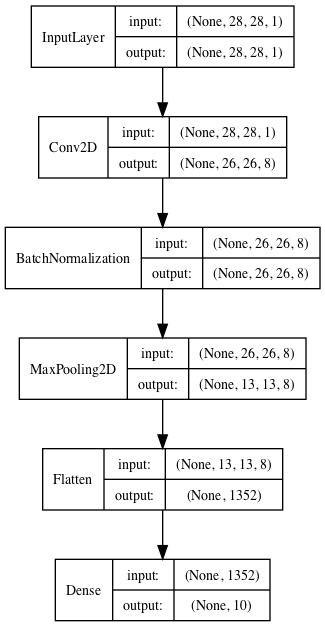

### 5.2 Single input - Multiple output

Here is an example of ConvNet with two output layers.

```python
# Define the input layer
X_input = layers.Input((28,28,1))

# Stack the shared layers
X = layers.Conv2D(8, (3,3), activation='relu')(X_input)
X = layers.BatchNormalization()(X)
X = layers.MaxPooling2D((2,2))(X)
    
# Define the 1st head
X_head1 = layers.Conv2D(16, (3,3), activation='relu')(X)
X_head1 = layers.MaxPooling2D((2,2))(X_head1)
X_head1 = layers.Flatten()(X_head1)
X_head1 = layers.Dense(10, activation='softmax', name="Output_1")(X_head1) # output 1

# Define the 2nd head
X_head2 = layers.Conv2D(32, (5,5), activation='relu')(X)
X_head2 = layers.MaxPooling2D((2,2))(X_head2)
X_head2 = layers.Flatten()(X_head2)
X_head2 = layers.Dense(4, activation='softmax', name="Output_2")(X_head2) # output 2

# Create the multi-output model
model = models.Model(inputs = X_input, outputs = [X_head1,X_head2])
```

The next figure shows a model with multiple outputs.

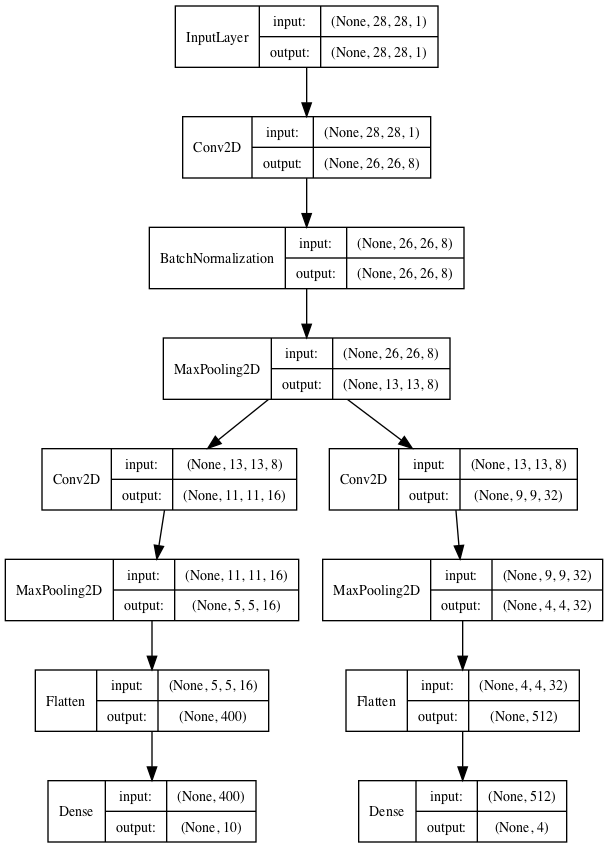

## 6. Multi-Label vs Multi-Output

In **multi-output** classification, the model provides a different output vector for each category in the training set. For example, the fashion dataset includes two categories with several sub-classes:

- **Category 1** = Clothing type
   - *Sub-class 1.1* = Jeans
   - *Sub-class 1.2* = Shoes
   - *Sub-class 1.3* = Dress
   - *Sub-class 1.4* = Shirt
   
   
- **Category 2** = Color
   - *Sub-class 2.1* = Black
   - *Sub-class 2.2* = Blue
   - *Sub-class 2.3* = Red
   
Hence, the network will have two output layers composed of 3 and 4 units, respectively. The mapping between the network outputs and the 7 sub-classes in the fashion dataset is as follows:

- **Output layer 1** = Color
  - Unit 1 = Black 
  - Unit 2 = Blue
  - Unit 3 = Red
  
- **Output layer 2** = Clothing type
  - Unit 1 = Jeans 
  - Unit 2 = Dress
  - Unit 3 = Shirt
  - Unit 4 = Shoes
  
The key difference here is that an item is always associated to two outputs. The cell below shows the one-hot encoded labels for the fashion dataset. Remark the difference with respect to the multi-label approach!

In [52]:
labels = np.array([key.split("_") for key, value in train_generator.class_indices.items()])

bin1 = LabelBinarizer()
bin2 = LabelBinarizer()

tag1 = bin1.fit_transform(labels[:,0])
tag2 = bin2.fit_transform(labels[:,1])

print(" color      cloth")
for i in range(len(labels)):
    print(tag1[i], "|", tag2[i], "-->", " ".join(labels[i]))

 color      cloth
[1 0 0] | [0 1 0 0] --> black jeans
[1 0 0] | [0 0 0 1] --> black shoes
[0 1 0] | [1 0 0 0] --> blue dress
[0 1 0] | [0 1 0 0] --> blue jeans
[0 1 0] | [0 0 1 0] --> blue shirt
[0 0 1] | [1 0 0 0] --> red dress
[0 0 1] | [0 0 1 0] --> red shirt


The following class extends the Keras generator, so as to produce the multi-output one-hot encoding.

In [53]:
class MultiOutputGenerator:
    
    def __init__(self, generator):
        self.generator = generator
        self.classes = np.array([key for key, value in generator.class_indices.items()])
        labels = np.array([tag.split("_") for tag in self.classes])
        self.tag1 = LabelBinarizer()
        self.tag1.fit(labels[:,0])
        self.tag2 = LabelBinarizer()
        self.tag2.fit(labels[:,1])
                
    def __next__(self):
        batch_x, batch_y = self.generator.next()
        idx = batch_y.argmax(axis=1)
        batch_y = self.classes[idx]
        batch_y = np.array([tag.split("_") for tag in batch_y])
        batch_y1 = self.tag1.transform(batch_y[:,0])
        batch_y2 = self.tag2.transform(batch_y[:,1])
        return batch_x, [batch_y1, batch_y2]

The code below prepares the generators for multi-output classification.

In [54]:
train_generator_multioutput = MultiOutputGenerator(train_generator)
valid_generator_multioutput = MultiOutputGenerator(valid_generator)

## 7. Multi-Output Classification

**Exercise:** Build a ConvNet for multi-output classification. It must predict the 2 categories in the fashion dataset.

- Define the architecture of your ConvNet.

- Fit the ConvNet on the training set.

- Evaluate its performance on the validation set.

- Test your trained ConvNet on the images in the folder `fashion_examples`.

**Tips:**

 - Since you are dealing with *multi-output* classification, you end the network with two output layers, both having a `softmax` activation. The number of units in these last layer is equal to the number of sub-classes in each category to predict. 
 
 
 - For multi-output classification, the loss function is `categorical_crossentropy`.
 
 
 - To visualize the layout of your ConvNet, you can use the function `plot_model()` as follows:
 ```
 utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)
 ```
 This is particularly useful to debug the definition of your model. (*Note that you need to install the package "graphviz" to use this function.*)

In [61]:
# Define the network. Hint: use the functional API
#model = ... # ADD CODE HERE
X_input = layers.Input((40,40,3))

# Stack the shared layers
X = layers.Conv2D(32, (3,3), activation='relu')(X_input)
X = layers.BatchNormalization()(X)
X = layers.MaxPooling2D((2,2))(X)

# Define the 1st head
X_head1 = layers.Conv2D(64, (3,3), activation='relu')(X)
X_head1 = layers.MaxPooling2D((2,2))(X_head1)
X_head1 = layers.Flatten()(X_head1)
X_head1 = layers.Dense(3, activation='softmax', name="Output_1")(X_head1) # output 1

# Define the 2nd head
X_head2 = layers.Conv2D(32, (5,5), activation='relu')(X)
X_head2 = layers.MaxPooling2D((2,2))(X_head2)
X_head2 = layers.Flatten()(X_head2)
X_head2 = layers.Dense(4, activation='softmax', name="Output_2")(X_head2) # output 2

# Create the multi-output model
model = models.Model(inputs = X_input, outputs = [X_head1,X_head2])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the network. Hint: use .fit_generator(...)
history =  model.fit_generator( train_generator_multioutput,steps_per_epoch=63,validation_data=valid_generator_multioutput,validation_steps=1,epochs=5) # ADD CODE HERE # ADD CODE HERE
#utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

Epoch 1/5
 7/63 [==>...........................] - ETA: 50s - loss: 1.7875 - Output_1_loss: 0.7202 - Output_2_loss: 1.0673 - Output_1_acc: 0.6875 - Output_2_acc: 0.5625

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


16/63 [======>.......................] - ETA: 43s - loss: 1.2665 - Output_1_loss: 0.4725 - Output_2_loss: 0.7940 - Output_1_acc: 0.8086 - Output_2_acc: 0.7090

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


28/63 [============>.................] - ETA: 31s - loss: 0.9809 - Output_1_loss: 0.3414 - Output_2_loss: 0.6395 - Output_1_acc: 0.8594 - Output_2_acc: 0.7723

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


42/63 [===================>..........] - ETA: 18s - loss: 0.7985 - Output_1_loss: 0.2632 - Output_2_loss: 0.5353 - Output_1_acc: 0.8936 - Output_2_acc: 0.8043

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


54/63 [========================>.....] - ETA: 8s - loss: 0.6903 - Output_1_loss: 0.2211 - Output_2_loss: 0.4693 - Output_1_acc: 0.9103 - Output_2_acc: 0.8252

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


63/63 [==============================] - 58s 926ms/step - loss: 0.6340 - Output_1_loss: 0.2006 - Output_2_loss: 0.4334 - Output_1_acc: 0.9186 - Output_2_acc: 0.8413 - val_loss: 0.2492 - val_Output_1_loss: 0.0934 - val_Output_2_loss: 0.1558 - val_Output_1_acc: 0.9661 - val_Output_2_acc: 0.9401
Epoch 2/5
 5/63 [=>............................] - ETA: 46s - loss: 0.3036 - Output_1_loss: 0.0912 - Output_2_loss: 0.2124 - Output_1_acc: 0.9563 - Output_2_acc: 0.9313

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


30/63 [=============>................] - ETA: 28s - loss: 0.2708 - Output_1_loss: 0.0803 - Output_2_loss: 0.1905 - Output_1_acc: 0.9667 - Output_2_acc: 0.9281

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


45/63 [====================>.........] - ETA: 16s - loss: 0.2548 - Output_1_loss: 0.0794 - Output_2_loss: 0.1754 - Output_1_acc: 0.9674 - Output_2_acc: 0.9396

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


52/63 [=======================>......] - ETA: 10s - loss: 0.2428 - Output_1_loss: 0.0768 - Output_2_loss: 0.1661 - Output_1_acc: 0.9681 - Output_2_acc: 0.9435

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


63/63 [==============================] - 60s 958ms/step - loss: 0.2277 - Output_1_loss: 0.0688 - Output_2_loss: 0.1589 - Output_1_acc: 0.9722 - Output_2_acc: 0.9444 - val_loss: 0.1918 - val_Output_1_loss: 0.0561 - val_Output_2_loss: 0.1357 - val_Output_1_acc: 0.9820 - val_Output_2_acc: 0.9501
Epoch 3/5
 2/63 [..............................] - ETA: 51s - loss: 0.2539 - Output_1_loss: 0.0492 - Output_2_loss: 0.2047 - Output_1_acc: 0.9844 - Output_2_acc: 0.9219

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


13/63 [=====>........................] - ETA: 46s - loss: 0.1606 - Output_1_loss: 0.0366 - Output_2_loss: 0.1240 - Output_1_acc: 0.9880 - Output_2_acc: 0.9639

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


33/63 [==============>...............] - ETA: 26s - loss: 0.1845 - Output_1_loss: 0.0592 - Output_2_loss: 0.1253 - Output_1_acc: 0.9782 - Output_2_acc: 0.9583

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


45/63 [====================>.........] - ETA: 15s - loss: 0.1764 - Output_1_loss: 0.0586 - Output_2_loss: 0.1178 - Output_1_acc: 0.9799 - Output_2_acc: 0.9625

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


63/63 [==============================] - 56s 887ms/step - loss: 0.1511 - Output_1_loss: 0.0463 - Output_2_loss: 0.1048 - Output_1_acc: 0.9846 - Output_2_acc: 0.9663 - val_loss: 0.1599 - val_Output_1_loss: 0.0158 - val_Output_2_loss: 0.1441 - val_Output_1_acc: 0.9920 - val_Output_2_acc: 0.9461
Epoch 4/5
 2/63 [..............................] - ETA: 53s - loss: 0.1380 - Output_1_loss: 0.0562 - Output_2_loss: 0.0818 - Output_1_acc: 0.9688 - Output_2_acc: 0.9688

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


63/63 [==============================] - 54s 859ms/step - loss: 0.0775 - Output_1_loss: 0.0310 - Output_2_loss: 0.0465 - Output_1_acc: 0.9881 - Output_2_acc: 0.9856 - val_loss: 0.1110 - val_Output_1_loss: 0.0128 - val_Output_2_loss: 0.0982 - val_Output_1_acc: 0.9960 - val_Output_2_acc: 0.9641
Epoch 5/5
 8/63 [==>...........................] - ETA: 44s - loss: 0.0456 - Output_1_loss: 0.0125 - Output_2_loss: 0.0331 - Output_1_acc: 0.9961 - Output_2_acc: 0.9922

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


63/63 [==============================] - 52s 832ms/step - loss: 0.1550 - Output_1_loss: 0.1119 - Output_2_loss: 0.0430 - Output_1_acc: 0.9683 - Output_2_acc: 0.9856 - val_loss: 0.6495 - val_Output_1_loss: 0.4425 - val_Output_2_loss: 0.2070 - val_Output_1_acc: 0.8643 - val_Output_2_acc: 0.9261


ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


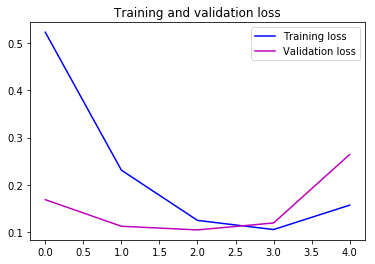

In [59]:
# Get the training info
loss     = history.history['loss']
val_loss = history.history['val_loss']

# Visualize the history plots
plt.figure()
plt.plot(loss, 'b', label='Training loss')
plt.plot(val_loss, 'm', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**Expected Output**:

<table>
    <tr>
        <td>
        </td>
        <td>
            Valid. accuracy
        </td>
    </tr>
    <tr>
        <td>
            Color
        </td>
        <td>
            around 99%
        </td>
    </tr>
    <tr>
        <td>
            Type
        </td>
        <td>
            around 97%
        </td>
    </tr>
</table>



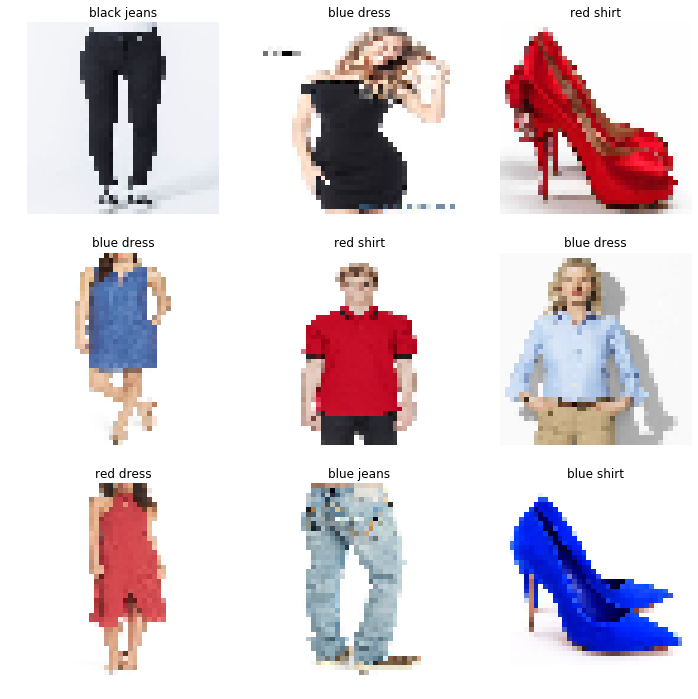

In [60]:
# Test the network
pred1, pred2 = model.predict(test_images)
color = pred1.argmax(axis=1)
cloth = pred2.argmax(axis=1)

# Get the multi-output categories
tag1 = train_generator_multioutput.tag1.inverse_transform(pred1)
tag2 = train_generator_multioutput.tag2.inverse_transform(pred2)

# Visualize the predictions
f, ax = plt.subplots(3, 3, figsize=(12,12))
for i, img in enumerate(test_images):
    ax.flat[i].imshow(img)
    ax.flat[i].axis("off")
    ax.flat[i].set_title(" ".join([tag1[i],tag2[i]]))  
plt.show()

Analyze the errors made by your ConvNet on the test images of never-seen-before clothing (black dress, red shoes, blue shoes):

- Your ConvNet is able to correctly predict the color.


- Depending on the architecture of your ConvNet, the prediction of the clothing type may still be wrong. 

## 7. Conclusion

**Remember:** There are the four steps for building a neural network in Keras: 
 1. Stack the layers with the `Sequential` class or the functional API
 - Compile the model
 - Fit/Train
 - Evaluate/Test